## California Climate Risk and Adaptation Index Demo
This notebook walks through the Cal-CRAI calculation using synthetic historical data to demonstrate potential scores of resilience across California. 

The Cal-CRAI quantifies the climate change adaptation and mitigation benefits of California Climate Investment (CCI) projects. This approach requires a climate science and stakeholder-led approach, and a flexible statistical methodology that will accurately and responsibly represent the diverse climate and socioeconomic needs of Californians. CCI programs are designed to reduce greenhouse gas emissions while providing socioeconomic, health, and ecosystem benefits within disadvantaged and low-income communities across California. The Cal-CRAI incorporates a wide range of multi-dimensional and diverse facets of climate risk, and will provide a critical quantification of where existing CCI projects and programs have contributed to climate adaptation benefits and can provide agencies with detailed information to prioritize climate adaptation as a critical objective when designing future programs, planning projects, selecting grant awards, and more. 

<font color='Red'>**Intended Application**</font>: I want to understand the Index results by: 
1. Calculating Cal-CRAI with equal weighted domains
2. Understanding potential weighting scenarios, where domains are weighted differently
3. Visualize the Cal-CRAI across California

### Step 0: Set-up
First we will import several useful libraries to aid analysis. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_index, weight_domains
from scripts.utils.index_plot import index_plot, index_domain_plot

### Step 1: Retrieve data
To calculate the Cal-CRAI index, we will read in the data calculated from synthetic historical profiles for each input indicator. We are currently producing and finalizing all data to demonstrate the final Cal-CRAI Index. 

In [2]:
# read in index data (per domain)
df = gpd.read_file('output_folder/calcrai_adjustedcols_ready.csv')
df = format_df(df)
df.head(5) # short view of the input data

,GEOID,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry
0,06001400100,0.678999,0.744960,0.542488,0.399889,0.487123,0.501464,0.495968,0.503406,0.502033,0.077635,-0.179079,None
1,06001400200,0.314080,0.152722,0.330226,0.484907,0.487123,0.501464,0.495968,0.503406,-0.692073,-0.344017,-0.004548,None
2,06001400300,0.548310,0.057964,0.499104,0.544448,0.487123,0.501464,0.495968,0.503406,-0.883130,-0.008547,0.117681,None
3,06001400400,0.579186,0.061492,0.414485,0.551648,0.487123,0.501464,0.495968,0.503406,-0.876016,-0.176638,0.132462,None
4,06001400500,0.536066,0.732863,0.589100,0.592911,0.487123,0.501464,0.495968,0.503406,0.477642,0.170228,0.217169,None


Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [3]:
climate_domain_min_max_data = pd.read_csv('DUMMY_climate_indicator_product.csv')
df['acute_risk'] = climate_domain_min_max_data[['min_max_standardized_from_product']] # add climate col to main df

### Step 2: Calculate Cal-CRAI

The Cal-CRAI is a complex equation that incorporates information across four critical domains: **Governance**, **Society and Economy**, **Built Environment**, and **Natural Environment** and assesses them against **Risk**. Each domain consists of data metrics and indicators to form a multi-dimensional representation of that domain. For example, the **Built Environment** includes information on transportation infrastructure (highway access, freight rail, bottlenecks, airports), communication infrastructure (broadband, transmission towers), utilities infrastructure (underground powerlines, # of PSPS events, wastewater treatment facilities), and housing vacancy and quality (# of vacant homes, median age of housing, # of mobile residential structures). A full comprehensive list of all incorporated data metrics and indicators per domain is available.  

The Cal-CRAI equation is as follows: 

\begin{equation*}
CalCRAI =  \frac{Gov_i + (A\cdot Soc_{adj}\cdot Gov_i) + (B\cdot BE_{adj}\cdot Gov_i) + (C\cdot NS_{adj}\cdot Gov_i)}{Risk_i}
\end{equation*}

\begin{equation*}
Soc_{adj} = \frac{Soc_i - Soc_m}{Soc_m}
\end{equation*}

where: 
- $Soc_i$ is the Society domain score for census tract "i"
- $Soc_m$ is the median Society domain score for all California census tracts
- The same process is applied for the Built Environment (BE) and Natural Systems (NS) domains

In [4]:
df_eq = weight_domains(df, society=1, built=1, natural=1)
df_eq = calculate_index(df_eq)

Let's print some results to see the range of values in the synthetic data. 

In [5]:
print('Min score / less resilience: ', df_eq['calcrai_score'].min())
print('Max score / more resilience: ', df_eq['calcrai_score'].max())
print('Mean score / average resilience: ', df_eq['calcrai_score'].mean())
print('Median score / median resilience: ', df_eq['calcrai_score'].median())

Min score / less resilience:  -22.570847302680153
Max score / more resilience:  219.4195876658281
Mean score / average resilience:  1.8796311166762065
Median score / median resilience:  1.3368048373474357


Let's also see how many census tracts have high resilience scores. We'll be diving further into the relationship between various domains and the resulting `calcrai_score` value. For example, how do high governance scores coupled with low risk impact the Index value? 

In [6]:
# how many census tracts have resilience scores above 10*mean
print(len(df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())]))
df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())].head(5)

10


,GEOID,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry,acute_risk,calcrai_weighted,calcrai_score
970,06019007202,0.582113,0.597278,0.717820,0.486292,0.487123,0.501464,0.495968,0.503406,0.204268,0.425926,-0.001706,None,0.004320,0.947965,219.419588
1274,06029005205,0.380623,0.543851,0.814987,0.628358,0.487123,0.501464,0.495968,0.503406,0.096545,0.618946,0.289937,None,0.011449,0.763312,66.671922
1756,06037143101,0.685121,0.755040,0.547150,0.410136,0.487123,0.501464,0.495968,0.503406,0.522358,0.086895,-0.158044,None,0.022651,0.994253,43.895146
1879,06037192520,0.550972,0.349798,0.703478,0.584049,0.487123,0.501464,0.495968,0.503406,-0.294715,0.397436,0.198977,None,0.010520,0.717198,68.175112
3424,06037576904,0.528613,0.488407,0.406956,0.495708,0.487123,0.501464,0.495968,0.503406,-0.015244,-0.191595,0.017624,None,0.002557,0.428591,167.588584


### Step 3: Visualize Results
Let's visualize the results! We'll also demonstrate the power of different customized weighting scenarios. 

In the cells below, we produce a map of the Cal-CRAI across California, as well as comparison maps of the input domains in order to provide context as to the relative importance of each domain in the final calculation. 

#### 3a) Equal Weighting of Domains
This is the "standard" version of the Cal-CRAI calculation -- where the input domains `Society & Economy`, `Built Environment`, and `Natural Systems` are equally weighted in importance. This ensures that we capture a baseline of conditions across California. 

**Note**: These maps are produced with *synthetic* data and do not represent the actual CalCRAI values per census tract. This "real" data is currently being calculated, and these maps will be updated!

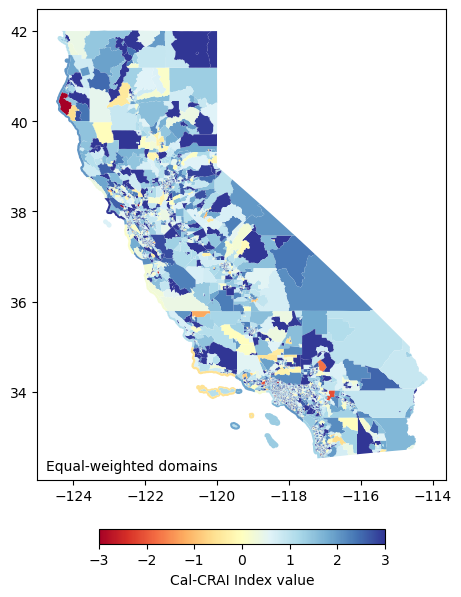

In [7]:
index_plot(df_eq)

To interpret these maps, a **positive** value indicates a high resilience score, while a **negative** value indicates a low resilience score. 

Now let's look at the input domains as well: 

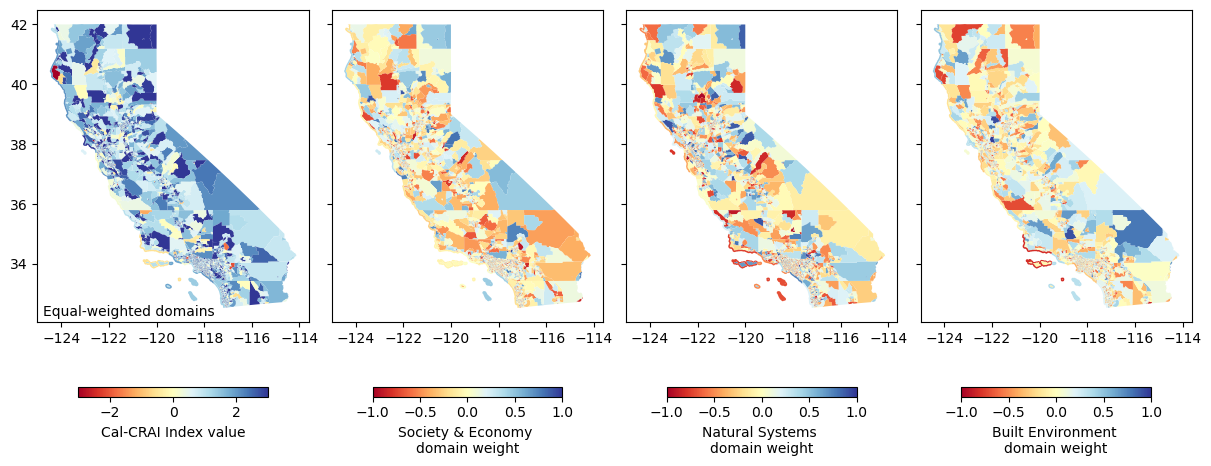

In [8]:
index_domain_plot(df_eq)

#### 3b) Custom Weighting Scenarios
We can also weight the domains differently to focus on a particular risk that may be important for your planning and research needs. In the example below, we provide a hypothetical weighting scenario where **wildfire** is of particular interest. We then set specific weights on each domain. Here, we have the `Natural Systems` domain weighted highly, as well as a modified `Built Environment`. 

In [12]:
# different weighting
df_fire = weight_domains(df, society=1.5, built=1, natural=3)
df_fire = calculate_index(df_fire)

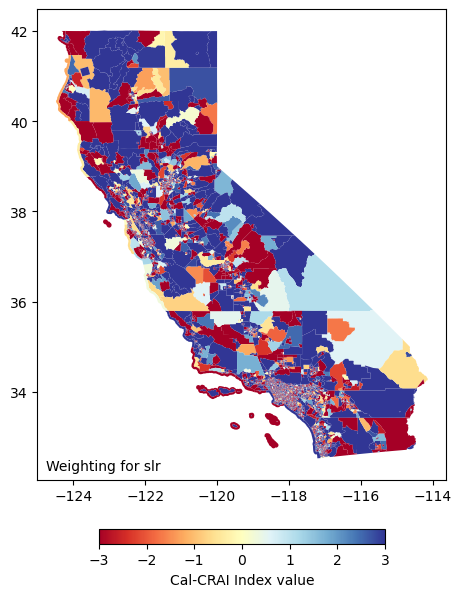

In [13]:
index_plot(df_fire, scenario='slr')

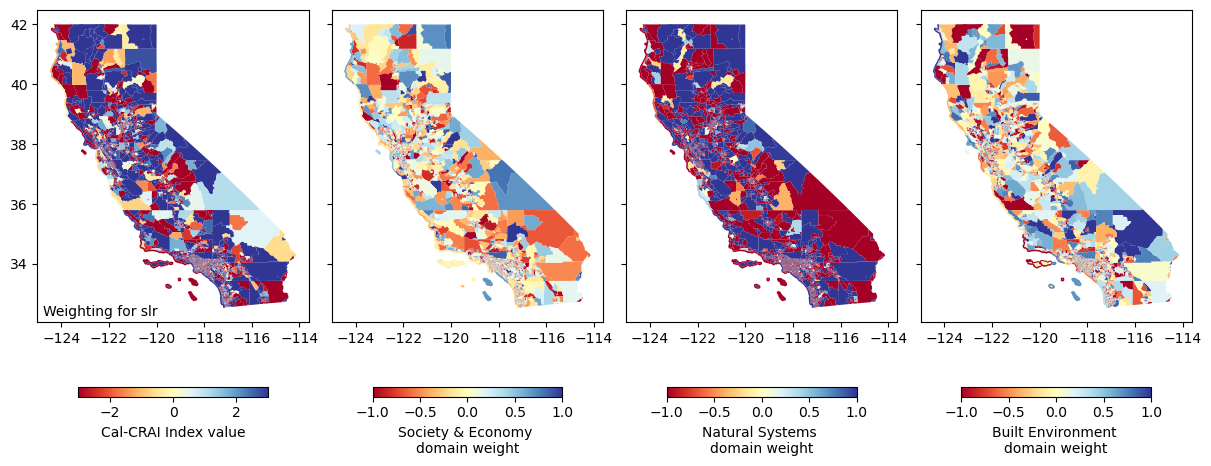

In [14]:
index_domain_plot(df_fire, scenario='slr', society=1.5, built=1, natural=3)

Each scenario is custom to your desired inputs, and flexible. We are also incorporating climate change, via chronic climate risk, into the Cal-CRAI calculation so as to understand how results may change depending on your area of interest. 

We want to make sure that the Cal-CRAI is useful for your needs:
- What kinds of customizations would be helpful for you in using the Cal-CRAI?
- What weighting scenarios are you interested in seeing and are responsive to your needs?
- What sorts of outputs from this tool would save you time when applying for funding opportunities?
